# 作业第7周：GAN练习

1.仿照课件示例的GAN生成网络，复现Fashion_mnist数据集的GAN生成效果或Mnist数据集的GAN生成效果。<BR>（学有余力同学可以挑战一下anime faces的GAN生成，建议使用WGAN）


In [19]:
#首先执行GPU资源分配代码，勿删除。
import tensorflow as tf
from tensorflow import keras
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(
        physical_devices[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=512)])

#### 数据预处理

In [23]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
print(x_train.shape, type(x_train[0]))
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype("float32")
x_train = (x_train - 127.5) / 127.5
buffer_size = 60000
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)
print(x_train.shape)

(60000, 28, 28) <class 'numpy.ndarray'>
(60000, 28, 28, 1)


#### 生成器模型

In [27]:
from keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None,7,7,256)#注意：batch size没有限制
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape == (None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape == (None,14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
    assert model.output_shape == (None,28,28,1)
    
    return model

In [28]:
generator = make_generator_model()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)        

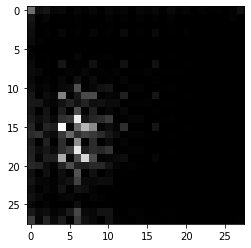

In [41]:
from matplotlib import pyplot as plt
%matplotlib inline

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap="gray")

#### 判别器模型

In [30]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [31]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print(decision)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

#### 损失函数

In [32]:
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    loss = real_loss + fake_loss
    return loss

def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    return loss

#### 优化器

In [33]:
generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)

#### 超参数

In [34]:
epochs = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

#### 定义训练过程

In [35]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size,noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output =discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss,disc_loss

In [46]:
import time
from IPython import display

def train(dataset,epochs):
    for epoch in range(epochs):
        start=time.time()
        for i,image_batch in enumerate(dataset):
            g,d = train_step(image_batch)
            print("batch %d, gen_loss %f, disc_loss %f" % (i,g.numpy(),d.numpy()))

    #     display.clear_output(wait=True)
    #     generate_images(generator,epoch+1)
              
        print('Time for epoch {} is {} sec'.format(epoch+1,time.time()-start))

#### 显示生成图片

In [43]:
def generate_images(model,test_input):
    predictions = model(test_input,training=False)
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:, :, 0]*127.5 + 127.5)
        plt.axis('off')
    plt.show()

#### 训练

In [44]:
%%time
train(train_dataset, epochs)

batch 0, gen_loss 0.973365, disc_loss 1.205098
batch 1, gen_loss 0.949555, disc_loss 1.274268
batch 2, gen_loss 0.927190, disc_loss 1.259077
batch 3, gen_loss 0.920719, disc_loss 1.206595
batch 4, gen_loss 0.895243, disc_loss 1.218703
batch 5, gen_loss 0.863761, disc_loss 1.183457
batch 6, gen_loss 0.843907, disc_loss 1.210892
batch 7, gen_loss 0.810288, disc_loss 1.258498
batch 8, gen_loss 0.786095, disc_loss 1.273002
batch 9, gen_loss 0.752759, disc_loss 1.268821
batch 10, gen_loss 0.740375, disc_loss 1.288656
batch 11, gen_loss 0.724757, disc_loss 1.299481
batch 12, gen_loss 0.687605, disc_loss 1.365397
batch 13, gen_loss 0.683535, disc_loss 1.339993
batch 14, gen_loss 0.666432, disc_loss 1.338384
batch 15, gen_loss 0.677672, disc_loss 1.350474
batch 16, gen_loss 0.671912, disc_loss 1.369936
batch 17, gen_loss 0.667088, disc_loss 1.378995
batch 18, gen_loss 0.676192, disc_loss 1.412810
batch 19, gen_loss 0.676989, disc_loss 1.397547
batch 20, gen_loss 0.670446, disc_loss 1.437206
ba

batch 175, gen_loss 0.902006, disc_loss 1.039192
batch 176, gen_loss 0.888885, disc_loss 1.028475
batch 177, gen_loss 0.883703, disc_loss 1.030850
batch 178, gen_loss 0.827818, disc_loss 1.101731
batch 179, gen_loss 0.840576, disc_loss 1.048503
batch 180, gen_loss 0.817764, disc_loss 1.112829
batch 181, gen_loss 0.785156, disc_loss 1.155848
batch 182, gen_loss 0.766163, disc_loss 1.157747
batch 183, gen_loss 0.781447, disc_loss 1.157531
batch 184, gen_loss 0.750349, disc_loss 1.217503
batch 185, gen_loss 0.728181, disc_loss 1.257064
batch 186, gen_loss 0.723361, disc_loss 1.285980
batch 187, gen_loss 0.699545, disc_loss 1.291667
batch 188, gen_loss 0.698415, disc_loss 1.300630
batch 189, gen_loss 0.713599, disc_loss 1.381328
batch 190, gen_loss 0.694662, disc_loss 1.457201
batch 191, gen_loss 0.682859, disc_loss 1.455931
batch 192, gen_loss 0.661958, disc_loss 1.557138
batch 193, gen_loss 0.651338, disc_loss 1.551038
batch 194, gen_loss 0.625851, disc_loss 1.611467
batch 195, gen_loss 

batch 112, gen_loss 0.896744, disc_loss 1.177297
batch 113, gen_loss 0.885314, disc_loss 1.163653
batch 114, gen_loss 0.864775, disc_loss 1.204385
batch 115, gen_loss 0.849493, disc_loss 1.177003
batch 116, gen_loss 0.835165, disc_loss 1.184986
batch 117, gen_loss 0.844606, disc_loss 1.169563
batch 118, gen_loss 0.839876, disc_loss 1.134502
batch 119, gen_loss 0.828468, disc_loss 1.095038
batch 120, gen_loss 0.835174, disc_loss 1.127608
batch 121, gen_loss 0.838710, disc_loss 1.136092
batch 122, gen_loss 0.851445, disc_loss 1.103093
batch 123, gen_loss 0.862296, disc_loss 1.061786
batch 124, gen_loss 0.871627, disc_loss 1.073275
batch 125, gen_loss 0.912722, disc_loss 1.078162
batch 126, gen_loss 0.933097, disc_loss 1.069324
batch 127, gen_loss 0.944709, disc_loss 0.974079
batch 128, gen_loss 0.990704, disc_loss 1.052299
batch 129, gen_loss 1.006728, disc_loss 1.005832
batch 130, gen_loss 1.001412, disc_loss 1.022235
batch 131, gen_loss 1.025192, disc_loss 1.039272
batch 132, gen_loss 

batch 49, gen_loss 0.873986, disc_loss 1.438680
batch 50, gen_loss 0.869339, disc_loss 1.439620
batch 51, gen_loss 0.892014, disc_loss 1.403201
batch 52, gen_loss 0.896818, disc_loss 1.334426
batch 53, gen_loss 0.864334, disc_loss 1.406611
batch 54, gen_loss 0.915452, disc_loss 1.313156
batch 55, gen_loss 0.938594, disc_loss 1.319032
batch 56, gen_loss 0.929838, disc_loss 1.345933
batch 57, gen_loss 0.925887, disc_loss 1.260824
batch 58, gen_loss 0.935094, disc_loss 1.288568
batch 59, gen_loss 0.932163, disc_loss 1.197364
batch 60, gen_loss 0.944255, disc_loss 1.217149
batch 61, gen_loss 0.931012, disc_loss 1.241527
batch 62, gen_loss 0.947803, disc_loss 1.206698
batch 63, gen_loss 0.954108, disc_loss 1.176582
batch 64, gen_loss 0.962122, disc_loss 1.162250
batch 65, gen_loss 0.965749, disc_loss 1.148714
batch 66, gen_loss 0.961919, disc_loss 1.160586
batch 67, gen_loss 0.936419, disc_loss 1.168876
batch 68, gen_loss 0.924488, disc_loss 1.138278
batch 69, gen_loss 0.936943, disc_loss 1

batch 224, gen_loss 0.910378, disc_loss 1.319093
batch 225, gen_loss 0.923181, disc_loss 1.317703
batch 226, gen_loss 0.827828, disc_loss 1.368962
batch 227, gen_loss 0.846821, disc_loss 1.491833
batch 228, gen_loss 0.874613, disc_loss 1.424515
batch 229, gen_loss 0.855295, disc_loss 1.450278
batch 230, gen_loss 0.844800, disc_loss 1.449180
batch 231, gen_loss 0.828419, disc_loss 1.478395
batch 232, gen_loss 0.838163, disc_loss 1.530560
batch 233, gen_loss 0.776498, disc_loss 1.516842
batch 234, gen_loss 0.818758, disc_loss 1.560781
Time for epoch3is 7.527757167816162 sec
batch 0, gen_loss 0.768889, disc_loss 1.541405
batch 1, gen_loss 0.675157, disc_loss 1.617701
batch 2, gen_loss 0.703712, disc_loss 1.547845
batch 3, gen_loss 0.669272, disc_loss 1.600746
batch 4, gen_loss 0.738614, disc_loss 1.593911
batch 5, gen_loss 0.715689, disc_loss 1.564979
batch 6, gen_loss 0.694689, disc_loss 1.612158
batch 7, gen_loss 0.682387, disc_loss 1.653305
batch 8, gen_loss 0.699238, disc_loss 1.56144

batch 160, gen_loss 0.924254, disc_loss 1.210369
batch 161, gen_loss 0.932780, disc_loss 1.161019
batch 162, gen_loss 0.943448, disc_loss 1.176529
batch 163, gen_loss 0.954690, disc_loss 1.184012
batch 164, gen_loss 0.959118, disc_loss 1.164186
batch 165, gen_loss 0.938451, disc_loss 1.175733
batch 166, gen_loss 0.963425, disc_loss 1.131889
batch 167, gen_loss 0.959262, disc_loss 1.149305
batch 168, gen_loss 0.975233, disc_loss 1.148172
batch 169, gen_loss 0.937233, disc_loss 1.135040
batch 170, gen_loss 0.967639, disc_loss 1.107081
batch 171, gen_loss 0.937995, disc_loss 1.119603
batch 172, gen_loss 0.941004, disc_loss 1.129576
batch 173, gen_loss 0.956686, disc_loss 1.112550
batch 174, gen_loss 0.947885, disc_loss 1.091616
batch 175, gen_loss 0.967284, disc_loss 1.111860
batch 176, gen_loss 0.984487, disc_loss 1.046351
batch 177, gen_loss 0.968923, disc_loss 1.066885
batch 178, gen_loss 0.975322, disc_loss 1.060869
batch 179, gen_loss 0.979291, disc_loss 1.055957
batch 180, gen_loss 

batch 98, gen_loss 0.951639, disc_loss 1.076691
batch 99, gen_loss 0.935353, disc_loss 1.103670
batch 100, gen_loss 0.951953, disc_loss 1.117000
batch 101, gen_loss 0.969329, disc_loss 1.118548
batch 102, gen_loss 0.953535, disc_loss 1.124945
batch 103, gen_loss 0.925558, disc_loss 1.124799
batch 104, gen_loss 0.916025, disc_loss 1.137879
batch 105, gen_loss 0.900283, disc_loss 1.151864
batch 106, gen_loss 0.891819, disc_loss 1.179223
batch 107, gen_loss 0.905630, disc_loss 1.141999
batch 108, gen_loss 0.868488, disc_loss 1.176712
batch 109, gen_loss 0.879421, disc_loss 1.171066
batch 110, gen_loss 0.891371, disc_loss 1.174269
batch 111, gen_loss 0.893710, disc_loss 1.189456
batch 112, gen_loss 0.889439, disc_loss 1.164467
batch 113, gen_loss 0.897898, disc_loss 1.237350
batch 114, gen_loss 0.903451, disc_loss 1.243576
batch 115, gen_loss 0.896657, disc_loss 1.222287
batch 116, gen_loss 0.894319, disc_loss 1.251416
batch 117, gen_loss 0.856015, disc_loss 1.289410
batch 118, gen_loss 0.

batch 35, gen_loss 0.722661, disc_loss 1.427700
batch 36, gen_loss 0.753413, disc_loss 1.390822
batch 37, gen_loss 0.742888, disc_loss 1.433477
batch 38, gen_loss 0.730103, disc_loss 1.452434
batch 39, gen_loss 0.761243, disc_loss 1.413728
batch 40, gen_loss 0.758471, disc_loss 1.410486
batch 41, gen_loss 0.761151, disc_loss 1.404961
batch 42, gen_loss 0.753579, disc_loss 1.390191
batch 43, gen_loss 0.757833, disc_loss 1.420213
batch 44, gen_loss 0.743617, disc_loss 1.401225
batch 45, gen_loss 0.734719, disc_loss 1.386405
batch 46, gen_loss 0.744937, disc_loss 1.396183
batch 47, gen_loss 0.749188, disc_loss 1.388594
batch 48, gen_loss 0.736826, disc_loss 1.394167
batch 49, gen_loss 0.733861, disc_loss 1.409954
batch 50, gen_loss 0.745544, disc_loss 1.410465
batch 51, gen_loss 0.730989, disc_loss 1.430820
batch 52, gen_loss 0.739076, disc_loss 1.381236
batch 53, gen_loss 0.762034, disc_loss 1.423095
batch 54, gen_loss 0.742629, disc_loss 1.395052
batch 55, gen_loss 0.761083, disc_loss 1

batch 210, gen_loss 0.827097, disc_loss 1.354681
batch 211, gen_loss 0.821538, disc_loss 1.339834
batch 212, gen_loss 0.828125, disc_loss 1.294966
batch 213, gen_loss 0.819181, disc_loss 1.363316
batch 214, gen_loss 0.826746, disc_loss 1.370885
batch 215, gen_loss 0.808922, disc_loss 1.352174
batch 216, gen_loss 0.820783, disc_loss 1.324664
batch 217, gen_loss 0.845352, disc_loss 1.298113
batch 218, gen_loss 0.813208, disc_loss 1.312691
batch 219, gen_loss 0.823580, disc_loss 1.289982
batch 220, gen_loss 0.830780, disc_loss 1.362729
batch 221, gen_loss 0.822648, disc_loss 1.359110
batch 222, gen_loss 0.816161, disc_loss 1.364224
batch 223, gen_loss 0.843455, disc_loss 1.320302
batch 224, gen_loss 0.826464, disc_loss 1.318136
batch 225, gen_loss 0.829932, disc_loss 1.320539
batch 226, gen_loss 0.848853, disc_loss 1.320483
batch 227, gen_loss 0.871609, disc_loss 1.307076
batch 228, gen_loss 0.856848, disc_loss 1.335310
batch 229, gen_loss 0.873508, disc_loss 1.295408
batch 230, gen_loss 

batch 147, gen_loss 0.662868, disc_loss 1.577420
batch 148, gen_loss 0.672519, disc_loss 1.569528
batch 149, gen_loss 0.666022, disc_loss 1.478029
batch 150, gen_loss 0.669299, disc_loss 1.469110
batch 151, gen_loss 0.661088, disc_loss 1.504355
batch 152, gen_loss 0.667843, disc_loss 1.416164
batch 153, gen_loss 0.711101, disc_loss 1.334211
batch 154, gen_loss 0.708579, disc_loss 1.406422
batch 155, gen_loss 0.733416, disc_loss 1.348836
batch 156, gen_loss 0.725515, disc_loss 1.356979
batch 157, gen_loss 0.746652, disc_loss 1.305140
batch 158, gen_loss 0.759087, disc_loss 1.267341
batch 159, gen_loss 0.784556, disc_loss 1.236132
batch 160, gen_loss 0.777707, disc_loss 1.262343
batch 161, gen_loss 0.797613, disc_loss 1.251992
batch 162, gen_loss 0.818694, disc_loss 1.214074
batch 163, gen_loss 0.826772, disc_loss 1.196975
batch 164, gen_loss 0.852768, disc_loss 1.185032
batch 165, gen_loss 0.866673, disc_loss 1.147899
batch 166, gen_loss 0.853643, disc_loss 1.179403
batch 167, gen_loss 

batch 84, gen_loss 0.973749, disc_loss 1.209022
batch 85, gen_loss 0.931619, disc_loss 1.261704
batch 86, gen_loss 0.996801, disc_loss 1.250285
batch 87, gen_loss 0.985073, disc_loss 1.236158
batch 88, gen_loss 0.953228, disc_loss 1.267289
batch 89, gen_loss 0.953887, disc_loss 1.295439
batch 90, gen_loss 0.930629, disc_loss 1.311641
batch 91, gen_loss 0.873651, disc_loss 1.331001
batch 92, gen_loss 0.864714, disc_loss 1.290495
batch 93, gen_loss 0.875699, disc_loss 1.303364
batch 94, gen_loss 0.860147, disc_loss 1.347954
batch 95, gen_loss 0.855101, disc_loss 1.346337
batch 96, gen_loss 0.836647, disc_loss 1.378606
batch 97, gen_loss 0.832224, disc_loss 1.356051
batch 98, gen_loss 0.838571, disc_loss 1.371131
batch 99, gen_loss 0.812008, disc_loss 1.366280
batch 100, gen_loss 0.815191, disc_loss 1.395068
batch 101, gen_loss 0.803812, disc_loss 1.406246
batch 102, gen_loss 0.799026, disc_loss 1.399446
batch 103, gen_loss 0.776048, disc_loss 1.399099
batch 104, gen_loss 0.769858, disc_l

batch 21, gen_loss 0.810004, disc_loss 1.405895
batch 22, gen_loss 0.800359, disc_loss 1.352217
batch 23, gen_loss 0.809503, disc_loss 1.373002
batch 24, gen_loss 0.793625, disc_loss 1.370734
batch 25, gen_loss 0.787652, disc_loss 1.367358
batch 26, gen_loss 0.775353, disc_loss 1.362376
batch 27, gen_loss 0.766735, disc_loss 1.361755
batch 28, gen_loss 0.786645, disc_loss 1.373210
batch 29, gen_loss 0.763986, disc_loss 1.390540
batch 30, gen_loss 0.794587, disc_loss 1.371912
batch 31, gen_loss 0.793894, disc_loss 1.303910
batch 32, gen_loss 0.786043, disc_loss 1.344376
batch 33, gen_loss 0.789002, disc_loss 1.349930
batch 34, gen_loss 0.804354, disc_loss 1.276519
batch 35, gen_loss 0.785917, disc_loss 1.268921
batch 36, gen_loss 0.799768, disc_loss 1.306526
batch 37, gen_loss 0.853165, disc_loss 1.298201
batch 38, gen_loss 0.827080, disc_loss 1.333294
batch 39, gen_loss 0.865185, disc_loss 1.253273
batch 40, gen_loss 0.862826, disc_loss 1.262675
batch 41, gen_loss 0.836493, disc_loss 1

batch 196, gen_loss 0.670863, disc_loss 1.911515
batch 197, gen_loss 0.633821, disc_loss 1.857857
batch 198, gen_loss 0.646735, disc_loss 1.897283
batch 199, gen_loss 0.611709, disc_loss 1.838414
batch 200, gen_loss 0.623183, disc_loss 1.850710
batch 201, gen_loss 0.611948, disc_loss 1.819591
batch 202, gen_loss 0.629776, disc_loss 1.776833
batch 203, gen_loss 0.590322, disc_loss 1.815200
batch 204, gen_loss 0.599935, disc_loss 1.869425
batch 205, gen_loss 0.661258, disc_loss 1.843721
batch 206, gen_loss 0.654077, disc_loss 1.761563
batch 207, gen_loss 0.670138, disc_loss 1.775016
batch 208, gen_loss 0.700946, disc_loss 1.796274
batch 209, gen_loss 0.705779, disc_loss 1.705191
batch 210, gen_loss 0.719556, disc_loss 1.712088
batch 211, gen_loss 0.724765, disc_loss 1.636659
batch 212, gen_loss 0.722296, disc_loss 1.609260
batch 213, gen_loss 0.713163, disc_loss 1.628874
batch 214, gen_loss 0.702035, disc_loss 1.587710
batch 215, gen_loss 0.711967, disc_loss 1.511604
batch 216, gen_loss 

batch 133, gen_loss 0.930044, disc_loss 1.149492
batch 134, gen_loss 0.954088, disc_loss 1.101883
batch 135, gen_loss 0.961213, disc_loss 1.087577
batch 136, gen_loss 0.944689, disc_loss 1.151497
batch 137, gen_loss 0.948945, disc_loss 1.095387
batch 138, gen_loss 0.964087, disc_loss 1.105906
batch 139, gen_loss 0.962434, disc_loss 1.082392
batch 140, gen_loss 0.953424, disc_loss 1.108527
batch 141, gen_loss 0.938141, disc_loss 1.094415
batch 142, gen_loss 0.946779, disc_loss 1.131871
batch 143, gen_loss 0.943747, disc_loss 1.103653
batch 144, gen_loss 0.932112, disc_loss 1.078037
batch 145, gen_loss 0.959096, disc_loss 1.049177
batch 146, gen_loss 0.925700, disc_loss 1.107397
batch 147, gen_loss 0.924035, disc_loss 1.067814
batch 148, gen_loss 0.947805, disc_loss 1.074437
batch 149, gen_loss 0.925249, disc_loss 1.053197
batch 150, gen_loss 0.943375, disc_loss 1.065826
batch 151, gen_loss 0.953040, disc_loss 1.069690
batch 152, gen_loss 0.974230, disc_loss 1.039874
batch 153, gen_loss 

batch 70, gen_loss 0.834831, disc_loss 1.343467
batch 71, gen_loss 0.846229, disc_loss 1.253455
batch 72, gen_loss 0.849528, disc_loss 1.293105
batch 73, gen_loss 0.848886, disc_loss 1.295573
batch 74, gen_loss 0.845080, disc_loss 1.321161
batch 75, gen_loss 0.839137, disc_loss 1.319376
batch 76, gen_loss 0.851516, disc_loss 1.297832
batch 77, gen_loss 0.837584, disc_loss 1.294483
batch 78, gen_loss 0.822818, disc_loss 1.290583
batch 79, gen_loss 0.824225, disc_loss 1.330554
batch 80, gen_loss 0.834971, disc_loss 1.320791
batch 81, gen_loss 0.811894, disc_loss 1.358621
batch 82, gen_loss 0.805492, disc_loss 1.325562
batch 83, gen_loss 0.817154, disc_loss 1.323121
batch 84, gen_loss 0.800193, disc_loss 1.348005
batch 85, gen_loss 0.810385, disc_loss 1.315757
batch 86, gen_loss 0.818538, disc_loss 1.363790
batch 87, gen_loss 0.861627, disc_loss 1.310974
batch 88, gen_loss 0.836310, disc_loss 1.269483
batch 89, gen_loss 0.894755, disc_loss 1.238176
batch 90, gen_loss 0.873696, disc_loss 1

batch 7, gen_loss 1.027970, disc_loss 1.089208
batch 8, gen_loss 1.019162, disc_loss 1.002986
batch 9, gen_loss 1.015030, disc_loss 1.091826
batch 10, gen_loss 1.004354, disc_loss 1.119779
batch 11, gen_loss 1.044177, disc_loss 1.119809
batch 12, gen_loss 0.989762, disc_loss 1.103877
batch 13, gen_loss 1.004578, disc_loss 1.109686
batch 14, gen_loss 0.943235, disc_loss 1.130026
batch 15, gen_loss 0.935043, disc_loss 1.179228
batch 16, gen_loss 0.943323, disc_loss 1.148976
batch 17, gen_loss 0.984920, disc_loss 1.191445
batch 18, gen_loss 0.948049, disc_loss 1.192547
batch 19, gen_loss 0.959202, disc_loss 1.164872
batch 20, gen_loss 0.942893, disc_loss 1.270298
batch 21, gen_loss 0.911040, disc_loss 1.205078
batch 22, gen_loss 0.924773, disc_loss 1.241055
batch 23, gen_loss 0.961671, disc_loss 1.227915
batch 24, gen_loss 0.938885, disc_loss 1.297727
batch 25, gen_loss 0.949446, disc_loss 1.264143
batch 26, gen_loss 0.971465, disc_loss 1.206584
batch 27, gen_loss 0.989331, disc_loss 1.23

batch 182, gen_loss 0.899238, disc_loss 1.490325
batch 183, gen_loss 0.979770, disc_loss 1.417559
batch 184, gen_loss 0.985026, disc_loss 1.388412
batch 185, gen_loss 0.979915, disc_loss 1.353887
batch 186, gen_loss 1.039434, disc_loss 1.357293
batch 187, gen_loss 1.053824, disc_loss 1.253016
batch 188, gen_loss 1.079989, disc_loss 1.264043
batch 189, gen_loss 1.075142, disc_loss 1.194067
batch 190, gen_loss 1.084162, disc_loss 1.247698
batch 191, gen_loss 1.083896, disc_loss 1.201075
batch 192, gen_loss 1.158949, disc_loss 1.165356
batch 193, gen_loss 1.116642, disc_loss 1.059262
batch 194, gen_loss 1.128865, disc_loss 1.084353
batch 195, gen_loss 1.064244, disc_loss 1.095017
batch 196, gen_loss 1.093372, disc_loss 1.045364
batch 197, gen_loss 1.166162, disc_loss 0.968803
batch 198, gen_loss 1.087731, disc_loss 1.064604
batch 199, gen_loss 1.140714, disc_loss 0.950479
batch 200, gen_loss 1.180762, disc_loss 0.951956
batch 201, gen_loss 1.216661, disc_loss 0.948685
batch 202, gen_loss 

batch 119, gen_loss 1.075938, disc_loss 0.990020
batch 120, gen_loss 1.076029, disc_loss 0.986800
batch 121, gen_loss 1.080725, disc_loss 0.982528
batch 122, gen_loss 1.083221, disc_loss 0.987665
batch 123, gen_loss 1.134743, disc_loss 0.952243
batch 124, gen_loss 1.102740, disc_loss 0.946613
batch 125, gen_loss 1.145133, disc_loss 0.904061
batch 126, gen_loss 1.150661, disc_loss 0.914550
batch 127, gen_loss 1.173855, disc_loss 0.872590
batch 128, gen_loss 1.173089, disc_loss 0.895891
batch 129, gen_loss 1.187350, disc_loss 0.882609
batch 130, gen_loss 1.130084, disc_loss 0.883542
batch 131, gen_loss 1.172971, disc_loss 0.814471
batch 132, gen_loss 1.160503, disc_loss 0.823054
batch 133, gen_loss 1.207390, disc_loss 0.846953
batch 134, gen_loss 1.248263, disc_loss 0.807545
batch 135, gen_loss 1.200394, disc_loss 0.839465
batch 136, gen_loss 1.245302, disc_loss 0.832572
batch 137, gen_loss 1.235084, disc_loss 0.817096
batch 138, gen_loss 1.249182, disc_loss 0.835394
batch 139, gen_loss 

batch 56, gen_loss 0.992143, disc_loss 1.180685
batch 57, gen_loss 1.024573, disc_loss 1.173926
batch 58, gen_loss 1.010016, disc_loss 1.130738
batch 59, gen_loss 0.942066, disc_loss 1.159889
batch 60, gen_loss 0.961347, disc_loss 1.200956
batch 61, gen_loss 1.025697, disc_loss 1.189162
batch 62, gen_loss 0.968138, disc_loss 1.175130
batch 63, gen_loss 0.954769, disc_loss 1.178937
batch 64, gen_loss 0.985453, disc_loss 1.157687
batch 65, gen_loss 0.955974, disc_loss 1.194878
batch 66, gen_loss 1.025681, disc_loss 1.154714
batch 67, gen_loss 0.960182, disc_loss 1.280585
batch 68, gen_loss 1.031046, disc_loss 1.112694
batch 69, gen_loss 1.040729, disc_loss 1.179870
batch 70, gen_loss 0.988868, disc_loss 1.178150
batch 71, gen_loss 1.006277, disc_loss 1.188797
batch 72, gen_loss 0.992549, disc_loss 1.169017
batch 73, gen_loss 0.978850, disc_loss 1.100296
batch 74, gen_loss 0.962078, disc_loss 1.198587
batch 75, gen_loss 1.027733, disc_loss 1.166317
batch 76, gen_loss 1.072585, disc_loss 1

batch 231, gen_loss 1.022829, disc_loss 1.217269
batch 232, gen_loss 0.974268, disc_loss 1.278015
batch 233, gen_loss 0.971906, disc_loss 1.290306
batch 234, gen_loss 0.992087, disc_loss 1.223649
Time for epoch14is 7.556152820587158 sec
batch 0, gen_loss 1.013043, disc_loss 1.321532
batch 1, gen_loss 0.992091, disc_loss 1.324971
batch 2, gen_loss 0.965964, disc_loss 1.319601
batch 3, gen_loss 0.933128, disc_loss 1.348042
batch 4, gen_loss 0.966968, disc_loss 1.336639
batch 5, gen_loss 0.977185, disc_loss 1.275127
batch 6, gen_loss 0.966936, disc_loss 1.325719
batch 7, gen_loss 0.989061, disc_loss 1.270114
batch 8, gen_loss 0.992178, disc_loss 1.285482
batch 9, gen_loss 1.040692, disc_loss 1.241925
batch 10, gen_loss 1.014473, disc_loss 1.225545
batch 11, gen_loss 0.987238, disc_loss 1.266042
batch 12, gen_loss 1.029918, disc_loss 1.238937
batch 13, gen_loss 1.027752, disc_loss 1.207366
batch 14, gen_loss 1.044624, disc_loss 1.256414
batch 15, gen_loss 1.117126, disc_loss 1.128281
batch

batch 166, gen_loss 1.000409, disc_loss 1.162887
batch 167, gen_loss 1.073774, disc_loss 1.160338
batch 168, gen_loss 1.023712, disc_loss 1.198633
batch 169, gen_loss 1.027810, disc_loss 1.201932
batch 170, gen_loss 1.017627, disc_loss 1.165823
batch 171, gen_loss 1.011724, disc_loss 1.203415
batch 172, gen_loss 1.012289, disc_loss 1.227988
batch 173, gen_loss 1.033559, disc_loss 1.235369
batch 174, gen_loss 1.017314, disc_loss 1.153848
batch 175, gen_loss 0.971230, disc_loss 1.162654
batch 176, gen_loss 0.989115, disc_loss 1.195904
batch 177, gen_loss 0.944423, disc_loss 1.281629
batch 178, gen_loss 0.967863, disc_loss 1.224590
batch 179, gen_loss 0.990281, disc_loss 1.144081
batch 180, gen_loss 1.022257, disc_loss 1.198763
batch 181, gen_loss 1.008838, disc_loss 1.261997
batch 182, gen_loss 0.990326, disc_loss 1.226795
batch 183, gen_loss 1.039137, disc_loss 1.180701
batch 184, gen_loss 0.976582, disc_loss 1.218911
batch 185, gen_loss 0.944184, disc_loss 1.217811
batch 186, gen_loss 

batch 105, gen_loss 1.441017, disc_loss 0.804822
batch 106, gen_loss 1.408482, disc_loss 0.836503
batch 107, gen_loss 1.278850, disc_loss 0.879051
batch 108, gen_loss 1.316027, disc_loss 0.834108
batch 109, gen_loss 1.248734, disc_loss 0.860162
batch 110, gen_loss 1.257708, disc_loss 0.797181
batch 111, gen_loss 1.230979, disc_loss 0.825609
batch 112, gen_loss 1.370390, disc_loss 0.773032
batch 113, gen_loss 1.361386, disc_loss 0.773451
batch 114, gen_loss 1.351438, disc_loss 0.785064
batch 115, gen_loss 1.448323, disc_loss 0.774537
batch 116, gen_loss 1.420585, disc_loss 0.724396
batch 117, gen_loss 1.443273, disc_loss 0.734739
batch 118, gen_loss 1.432819, disc_loss 0.729314
batch 119, gen_loss 1.398066, disc_loss 0.727339
batch 120, gen_loss 1.388625, disc_loss 0.717673
batch 121, gen_loss 1.390097, disc_loss 0.760442
batch 122, gen_loss 1.409959, disc_loss 0.750046
batch 123, gen_loss 1.361653, disc_loss 0.748405
batch 124, gen_loss 1.317304, disc_loss 0.719648
batch 125, gen_loss 

batch 42, gen_loss 1.343042, disc_loss 0.858261
batch 43, gen_loss 1.361913, disc_loss 0.877189
batch 44, gen_loss 1.289383, disc_loss 0.834129
batch 45, gen_loss 1.290267, disc_loss 0.920330
batch 46, gen_loss 1.271238, disc_loss 0.897967
batch 47, gen_loss 1.311360, disc_loss 0.880519
batch 48, gen_loss 1.296859, disc_loss 0.882728
batch 49, gen_loss 1.360159, disc_loss 0.826674
batch 50, gen_loss 1.410351, disc_loss 0.852736
batch 51, gen_loss 1.342537, disc_loss 0.925600
batch 52, gen_loss 1.374928, disc_loss 0.851975
batch 53, gen_loss 1.323138, disc_loss 0.881090
batch 54, gen_loss 1.337353, disc_loss 0.915267
batch 55, gen_loss 1.348848, disc_loss 0.854712
batch 56, gen_loss 1.377855, disc_loss 0.842793
batch 57, gen_loss 1.411918, disc_loss 0.837190
batch 58, gen_loss 1.395457, disc_loss 0.823300
batch 59, gen_loss 1.459644, disc_loss 0.850650
batch 60, gen_loss 1.413692, disc_loss 0.857861
batch 61, gen_loss 1.481609, disc_loss 0.842485
batch 62, gen_loss 1.461771, disc_loss 0

batch 217, gen_loss 1.535252, disc_loss 0.754070
batch 218, gen_loss 1.413568, disc_loss 0.716676
batch 219, gen_loss 1.411873, disc_loss 0.723790
batch 220, gen_loss 1.476271, disc_loss 0.722264
batch 221, gen_loss 1.550099, disc_loss 0.678135
batch 222, gen_loss 1.535796, disc_loss 0.685403
batch 223, gen_loss 1.571085, disc_loss 0.642523
batch 224, gen_loss 1.566824, disc_loss 0.705164
batch 225, gen_loss 1.609060, disc_loss 0.641591
batch 226, gen_loss 1.554867, disc_loss 0.631334
batch 227, gen_loss 1.520871, disc_loss 0.659076
batch 228, gen_loss 1.609366, disc_loss 0.612971
batch 229, gen_loss 1.649114, disc_loss 0.654653
batch 230, gen_loss 1.630011, disc_loss 0.642618
batch 231, gen_loss 1.689687, disc_loss 0.635919
batch 232, gen_loss 1.659850, disc_loss 0.644120
batch 233, gen_loss 1.609723, disc_loss 0.661556
batch 234, gen_loss 1.641129, disc_loss 0.721564
Time for epoch17is 7.578449010848999 sec
batch 0, gen_loss 1.500582, disc_loss 0.603913
batch 1, gen_loss 1.527505, di

batch 152, gen_loss 1.242770, disc_loss 1.143825
batch 153, gen_loss 1.308245, disc_loss 1.004654
batch 154, gen_loss 1.317695, disc_loss 1.103099
batch 155, gen_loss 1.227899, disc_loss 1.072037
batch 156, gen_loss 1.162045, disc_loss 1.098661
batch 157, gen_loss 1.220358, disc_loss 1.056269
batch 158, gen_loss 1.300359, disc_loss 0.980078
batch 159, gen_loss 1.277387, disc_loss 1.015945
batch 160, gen_loss 1.348459, disc_loss 0.947617
batch 161, gen_loss 1.285624, disc_loss 1.015674
batch 162, gen_loss 1.282547, disc_loss 1.061364
batch 163, gen_loss 1.317166, disc_loss 1.039459
batch 164, gen_loss 1.315811, disc_loss 0.999173
batch 165, gen_loss 1.343803, disc_loss 0.950451
batch 166, gen_loss 1.270928, disc_loss 0.987964
batch 167, gen_loss 1.266083, disc_loss 0.932941
batch 168, gen_loss 1.286135, disc_loss 0.981074
batch 169, gen_loss 1.434503, disc_loss 0.926365
batch 170, gen_loss 1.375338, disc_loss 0.950448
batch 171, gen_loss 1.420277, disc_loss 1.010320
batch 172, gen_loss 

batch 91, gen_loss 1.501279, disc_loss 0.691531
batch 92, gen_loss 1.631975, disc_loss 0.693806
batch 93, gen_loss 1.777838, disc_loss 0.706055
batch 94, gen_loss 1.929050, disc_loss 0.730693
batch 95, gen_loss 1.746015, disc_loss 0.680247
batch 96, gen_loss 1.603575, disc_loss 0.753168
batch 97, gen_loss 1.571275, disc_loss 0.729003
batch 98, gen_loss 1.654548, disc_loss 0.718388
batch 99, gen_loss 1.628403, disc_loss 0.733948
batch 100, gen_loss 1.699843, disc_loss 0.868149
batch 101, gen_loss 1.741200, disc_loss 0.890423
batch 102, gen_loss 1.512136, disc_loss 0.825806
batch 103, gen_loss 1.582860, disc_loss 0.825388
batch 104, gen_loss 1.483491, disc_loss 0.834309
batch 105, gen_loss 1.487448, disc_loss 0.850884
batch 106, gen_loss 1.530693, disc_loss 0.894530
batch 107, gen_loss 1.653936, disc_loss 0.919857
batch 108, gen_loss 1.643410, disc_loss 0.819639
batch 109, gen_loss 1.516125, disc_loss 0.837367
batch 110, gen_loss 1.493814, disc_loss 0.911128
batch 111, gen_loss 1.571677,

batch 28, gen_loss 1.669997, disc_loss 0.676019
batch 29, gen_loss 1.624387, disc_loss 0.719104
batch 30, gen_loss 1.596181, disc_loss 0.708387
batch 31, gen_loss 1.652350, disc_loss 0.722430
batch 32, gen_loss 1.655508, disc_loss 0.739909
batch 33, gen_loss 1.688340, disc_loss 0.792706
batch 34, gen_loss 1.670311, disc_loss 0.705552
batch 35, gen_loss 1.489519, disc_loss 0.753163
batch 36, gen_loss 1.591409, disc_loss 0.839694
batch 37, gen_loss 1.576482, disc_loss 0.809829
batch 38, gen_loss 1.587494, disc_loss 0.900209
batch 39, gen_loss 1.604152, disc_loss 0.844949
batch 40, gen_loss 1.624118, disc_loss 0.920940
batch 41, gen_loss 1.518953, disc_loss 0.952015
batch 42, gen_loss 1.490936, disc_loss 0.985835
batch 43, gen_loss 1.346290, disc_loss 1.007135
batch 44, gen_loss 1.304922, disc_loss 1.035154
batch 45, gen_loss 1.433017, disc_loss 0.899207
batch 46, gen_loss 1.476355, disc_loss 1.108534
batch 47, gen_loss 1.415701, disc_loss 1.040722
batch 48, gen_loss 1.443517, disc_loss 1

batch 203, gen_loss 1.394048, disc_loss 0.922243
batch 204, gen_loss 1.316135, disc_loss 0.928988
batch 205, gen_loss 1.387753, disc_loss 0.846603
batch 206, gen_loss 1.416278, disc_loss 0.895127
batch 207, gen_loss 1.430215, disc_loss 0.882215
batch 208, gen_loss 1.430339, disc_loss 0.918037
batch 209, gen_loss 1.455655, disc_loss 0.876649
batch 210, gen_loss 1.535171, disc_loss 0.862882
batch 211, gen_loss 1.486662, disc_loss 0.892207
batch 212, gen_loss 1.513358, disc_loss 0.893194
batch 213, gen_loss 1.434102, disc_loss 0.821072
batch 214, gen_loss 1.475885, disc_loss 0.861402
batch 215, gen_loss 1.344587, disc_loss 0.940089
batch 216, gen_loss 1.384505, disc_loss 0.919912
batch 217, gen_loss 1.386135, disc_loss 0.866691
batch 218, gen_loss 1.341981, disc_loss 0.885817
batch 219, gen_loss 1.438775, disc_loss 0.809093
batch 220, gen_loss 1.381358, disc_loss 0.855979
batch 221, gen_loss 1.473537, disc_loss 0.914023
batch 222, gen_loss 1.487942, disc_loss 0.907977
batch 223, gen_loss 

batch 140, gen_loss 1.558348, disc_loss 0.794105
batch 141, gen_loss 1.595312, disc_loss 0.788344
batch 142, gen_loss 1.589227, disc_loss 0.713117
batch 143, gen_loss 1.512027, disc_loss 0.811686
batch 144, gen_loss 1.572992, disc_loss 0.760399
batch 145, gen_loss 1.553528, disc_loss 0.786722
batch 146, gen_loss 1.626755, disc_loss 0.732511
batch 147, gen_loss 1.631189, disc_loss 0.791485
batch 148, gen_loss 1.563071, disc_loss 0.729850
batch 149, gen_loss 1.556672, disc_loss 0.685926
batch 150, gen_loss 1.560990, disc_loss 0.813920
batch 151, gen_loss 1.549000, disc_loss 0.745132
batch 152, gen_loss 1.575956, disc_loss 0.848560
batch 153, gen_loss 1.563007, disc_loss 0.709463
batch 154, gen_loss 1.503820, disc_loss 0.751377
batch 155, gen_loss 1.698534, disc_loss 0.759328
batch 156, gen_loss 1.767657, disc_loss 0.816555
batch 157, gen_loss 1.652316, disc_loss 0.799137
batch 158, gen_loss 1.605231, disc_loss 0.770600
batch 159, gen_loss 1.502410, disc_loss 0.759316
batch 160, gen_loss 

batch 77, gen_loss 1.443743, disc_loss 0.819736
batch 78, gen_loss 1.476006, disc_loss 0.856813
batch 79, gen_loss 1.603155, disc_loss 0.777545
batch 80, gen_loss 1.653087, disc_loss 0.725973
batch 81, gen_loss 1.648309, disc_loss 0.788149
batch 82, gen_loss 1.641639, disc_loss 0.710036
batch 83, gen_loss 1.507335, disc_loss 0.713283
batch 84, gen_loss 1.594149, disc_loss 0.653226
batch 85, gen_loss 1.653851, disc_loss 0.667687
batch 86, gen_loss 1.836340, disc_loss 0.712922
batch 87, gen_loss 1.865585, disc_loss 0.661480
batch 88, gen_loss 1.748076, disc_loss 0.697483
batch 89, gen_loss 1.663743, disc_loss 0.644622
batch 90, gen_loss 1.620543, disc_loss 0.625105
batch 91, gen_loss 1.638589, disc_loss 0.580798
batch 92, gen_loss 1.813352, disc_loss 0.592385
batch 93, gen_loss 1.896069, disc_loss 0.625788
batch 94, gen_loss 1.898134, disc_loss 0.610823
batch 95, gen_loss 1.889036, disc_loss 0.604299
batch 96, gen_loss 1.921010, disc_loss 0.545432
batch 97, gen_loss 1.813981, disc_loss 0

batch 14, gen_loss 1.389669, disc_loss 1.146237
batch 15, gen_loss 1.388692, disc_loss 1.048190
batch 16, gen_loss 1.249208, disc_loss 1.073779
batch 17, gen_loss 1.291850, disc_loss 0.999094
batch 18, gen_loss 1.318599, disc_loss 0.981592
batch 19, gen_loss 1.350513, disc_loss 0.959740
batch 20, gen_loss 1.465324, disc_loss 1.017717
batch 21, gen_loss 1.425126, disc_loss 1.046584
batch 22, gen_loss 1.446026, disc_loss 0.924910
batch 23, gen_loss 1.343559, disc_loss 0.986859
batch 24, gen_loss 1.308729, disc_loss 0.989542
batch 25, gen_loss 1.265286, disc_loss 0.957704
batch 26, gen_loss 1.309263, disc_loss 0.984591
batch 27, gen_loss 1.296531, disc_loss 1.001961
batch 28, gen_loss 1.515098, disc_loss 0.864254
batch 29, gen_loss 1.714398, disc_loss 0.946082
batch 30, gen_loss 1.658390, disc_loss 0.929741
batch 31, gen_loss 1.360977, disc_loss 0.952753
batch 32, gen_loss 1.254080, disc_loss 0.869151
batch 33, gen_loss 1.254346, disc_loss 0.899750
batch 34, gen_loss 1.422972, disc_loss 0

batch 189, gen_loss 1.545518, disc_loss 0.762383
batch 190, gen_loss 1.723302, disc_loss 0.701387
batch 191, gen_loss 1.647191, disc_loss 0.744142
batch 192, gen_loss 1.701824, disc_loss 0.739846
batch 193, gen_loss 1.621047, disc_loss 0.781905
batch 194, gen_loss 1.673543, disc_loss 0.725181
batch 195, gen_loss 1.482309, disc_loss 0.769642
batch 196, gen_loss 1.513532, disc_loss 0.862719
batch 197, gen_loss 1.556038, disc_loss 0.843431
batch 198, gen_loss 1.535189, disc_loss 0.874303
batch 199, gen_loss 1.614158, disc_loss 0.800700
batch 200, gen_loss 1.454871, disc_loss 0.791239
batch 201, gen_loss 1.742232, disc_loss 0.748943
batch 202, gen_loss 1.650812, disc_loss 0.789304
batch 203, gen_loss 1.840842, disc_loss 0.684735
batch 204, gen_loss 1.823596, disc_loss 0.748898
batch 205, gen_loss 1.634527, disc_loss 0.705574
batch 206, gen_loss 1.505300, disc_loss 0.729672
batch 207, gen_loss 1.734529, disc_loss 0.739872
batch 208, gen_loss 1.751642, disc_loss 0.752171
batch 209, gen_loss 

batch 126, gen_loss 1.782759, disc_loss 0.671618
batch 127, gen_loss 1.839721, disc_loss 0.704598
batch 128, gen_loss 1.877356, disc_loss 0.655282
batch 129, gen_loss 1.934845, disc_loss 0.681559
batch 130, gen_loss 1.698333, disc_loss 0.651429
batch 131, gen_loss 1.728117, disc_loss 0.656109
batch 132, gen_loss 1.915908, disc_loss 0.637393
batch 133, gen_loss 1.861457, disc_loss 0.662409
batch 134, gen_loss 1.817222, disc_loss 0.650269
batch 135, gen_loss 1.757667, disc_loss 0.736201
batch 136, gen_loss 1.706994, disc_loss 0.742909
batch 137, gen_loss 1.831791, disc_loss 0.686443
batch 138, gen_loss 1.699994, disc_loss 0.684437
batch 139, gen_loss 1.836054, disc_loss 0.595279
batch 140, gen_loss 1.852470, disc_loss 0.761465
batch 141, gen_loss 1.765588, disc_loss 0.686138
batch 142, gen_loss 1.786420, disc_loss 0.742894
batch 143, gen_loss 1.735211, disc_loss 0.689340
batch 144, gen_loss 1.841694, disc_loss 0.748002
batch 145, gen_loss 1.814430, disc_loss 0.720978
batch 146, gen_loss 

batch 63, gen_loss 1.708416, disc_loss 0.705339
batch 64, gen_loss 1.852965, disc_loss 0.680510
batch 65, gen_loss 1.870756, disc_loss 0.616930
batch 66, gen_loss 1.833603, disc_loss 0.684254
batch 67, gen_loss 1.828857, disc_loss 0.702567
batch 68, gen_loss 1.777453, disc_loss 0.691269
batch 69, gen_loss 1.792764, disc_loss 0.635887
batch 70, gen_loss 1.881916, disc_loss 0.697094
batch 71, gen_loss 1.780161, disc_loss 0.688916
batch 72, gen_loss 1.851302, disc_loss 0.677069
batch 73, gen_loss 1.815814, disc_loss 0.722756
batch 74, gen_loss 1.697588, disc_loss 0.787267
batch 75, gen_loss 1.716713, disc_loss 0.697439
batch 76, gen_loss 1.740119, disc_loss 0.816475
batch 77, gen_loss 1.786877, disc_loss 0.751267
batch 78, gen_loss 1.857295, disc_loss 0.737968
batch 79, gen_loss 1.815855, disc_loss 0.730940
batch 80, gen_loss 1.817465, disc_loss 0.742160
batch 81, gen_loss 1.581449, disc_loss 0.869443
batch 82, gen_loss 1.578491, disc_loss 0.859103
batch 83, gen_loss 1.612787, disc_loss 0

batch 231, gen_loss 1.382598, disc_loss 0.854160
batch 232, gen_loss 1.621457, disc_loss 0.780727
batch 233, gen_loss 1.668365, disc_loss 0.776421
batch 234, gen_loss 1.670920, disc_loss 0.865542
Time for epoch25is 7.611479043960571 sec
batch 0, gen_loss 1.541191, disc_loss 0.717004
batch 1, gen_loss 1.530613, disc_loss 0.856405
batch 2, gen_loss 1.561556, disc_loss 0.802960
batch 3, gen_loss 1.596113, disc_loss 0.723474
batch 4, gen_loss 1.568326, disc_loss 0.772852
batch 5, gen_loss 1.620473, disc_loss 0.789237
batch 6, gen_loss 1.796813, disc_loss 0.709592
batch 7, gen_loss 1.720999, disc_loss 0.710846
batch 8, gen_loss 1.655159, disc_loss 0.811230
batch 9, gen_loss 1.801172, disc_loss 0.674005
batch 10, gen_loss 1.714381, disc_loss 0.695348
batch 11, gen_loss 1.701788, disc_loss 0.717043
batch 12, gen_loss 1.597570, disc_loss 0.739431
batch 13, gen_loss 1.668503, disc_loss 0.619889
batch 14, gen_loss 1.565363, disc_loss 0.677542
batch 15, gen_loss 1.649744, disc_loss 0.669303
batch

batch 168, gen_loss 1.809365, disc_loss 0.787897
batch 169, gen_loss 1.951698, disc_loss 0.826456
batch 170, gen_loss 1.755131, disc_loss 0.768567
batch 171, gen_loss 1.630438, disc_loss 0.737800
batch 172, gen_loss 1.595960, disc_loss 0.763391
batch 173, gen_loss 1.596117, disc_loss 0.798779
batch 174, gen_loss 1.515964, disc_loss 0.858687
batch 175, gen_loss 1.587139, disc_loss 0.839153
batch 176, gen_loss 1.673390, disc_loss 0.843837
batch 177, gen_loss 1.567929, disc_loss 0.809995
batch 178, gen_loss 1.604146, disc_loss 0.826689
batch 179, gen_loss 1.637313, disc_loss 0.751579
batch 180, gen_loss 1.537094, disc_loss 0.918939
batch 181, gen_loss 1.466707, disc_loss 0.877718
batch 182, gen_loss 1.449316, disc_loss 0.827854
batch 183, gen_loss 1.525715, disc_loss 0.828679
batch 184, gen_loss 1.452353, disc_loss 0.809203
batch 185, gen_loss 1.615879, disc_loss 0.881165
batch 186, gen_loss 1.619307, disc_loss 0.841474
batch 187, gen_loss 1.571014, disc_loss 0.933332
batch 188, gen_loss 

batch 105, gen_loss 1.561457, disc_loss 0.756256
batch 106, gen_loss 1.690585, disc_loss 0.679949
batch 107, gen_loss 1.771728, disc_loss 0.843948
batch 108, gen_loss 1.804997, disc_loss 0.749540
batch 109, gen_loss 1.908331, disc_loss 0.711831
batch 110, gen_loss 1.793463, disc_loss 0.730878
batch 111, gen_loss 1.775897, disc_loss 0.776552
batch 112, gen_loss 1.632760, disc_loss 0.653147
batch 113, gen_loss 1.688502, disc_loss 0.702470
batch 114, gen_loss 1.694914, disc_loss 0.733957
batch 115, gen_loss 1.672551, disc_loss 0.698050
batch 116, gen_loss 1.800040, disc_loss 0.652822
batch 117, gen_loss 1.817826, disc_loss 0.690159
batch 118, gen_loss 1.893779, disc_loss 0.686376
batch 119, gen_loss 1.905205, disc_loss 0.675865
batch 120, gen_loss 1.801536, disc_loss 0.723827
batch 121, gen_loss 1.671212, disc_loss 0.684159
batch 122, gen_loss 1.700513, disc_loss 0.703046
batch 123, gen_loss 1.787497, disc_loss 0.732941
batch 124, gen_loss 1.735480, disc_loss 0.663915
batch 125, gen_loss 

batch 42, gen_loss 1.450490, disc_loss 0.847320
batch 43, gen_loss 1.245214, disc_loss 0.938053
batch 44, gen_loss 1.416660, disc_loss 0.888670
batch 45, gen_loss 1.568894, disc_loss 0.839763
batch 46, gen_loss 1.655870, disc_loss 0.878593
batch 47, gen_loss 1.778952, disc_loss 0.900587
batch 48, gen_loss 1.838034, disc_loss 0.884473
batch 49, gen_loss 1.758623, disc_loss 0.872658
batch 50, gen_loss 1.481134, disc_loss 0.987763
batch 51, gen_loss 1.377828, disc_loss 0.867425
batch 52, gen_loss 1.252614, disc_loss 0.923804
batch 53, gen_loss 1.466862, disc_loss 0.878704
batch 54, gen_loss 1.609453, disc_loss 1.031388
batch 55, gen_loss 1.641982, disc_loss 0.886135
batch 56, gen_loss 1.775960, disc_loss 0.828125
batch 57, gen_loss 1.672708, disc_loss 0.839447
batch 58, gen_loss 1.538024, disc_loss 0.855238
batch 59, gen_loss 1.392810, disc_loss 0.883825
batch 60, gen_loss 1.427410, disc_loss 0.877532
batch 61, gen_loss 1.453671, disc_loss 0.850563
batch 62, gen_loss 1.435834, disc_loss 0

batch 217, gen_loss 1.861315, disc_loss 0.688347
batch 218, gen_loss 1.710743, disc_loss 0.711737
batch 219, gen_loss 1.793501, disc_loss 0.740218
batch 220, gen_loss 1.754269, disc_loss 0.672104
batch 221, gen_loss 1.684079, disc_loss 0.711801
batch 222, gen_loss 1.906494, disc_loss 0.756212
batch 223, gen_loss 1.788853, disc_loss 0.769419
batch 224, gen_loss 1.557125, disc_loss 0.845254
batch 225, gen_loss 1.677296, disc_loss 0.686181
batch 226, gen_loss 1.631709, disc_loss 0.742019
batch 227, gen_loss 1.620969, disc_loss 0.744354
batch 228, gen_loss 1.723747, disc_loss 0.742708
batch 229, gen_loss 1.692924, disc_loss 0.784488
batch 230, gen_loss 1.911427, disc_loss 0.837834
batch 231, gen_loss 1.744161, disc_loss 0.693004
batch 232, gen_loss 1.669463, disc_loss 0.717359
batch 233, gen_loss 1.549777, disc_loss 0.762709
batch 234, gen_loss 1.699018, disc_loss 0.839154
Time for epoch28is 7.618254899978638 sec
batch 0, gen_loss 1.680623, disc_loss 0.827776
batch 1, gen_loss 1.733496, di

batch 154, gen_loss 1.601526, disc_loss 0.786642
batch 155, gen_loss 1.522151, disc_loss 0.787133
batch 156, gen_loss 1.623997, disc_loss 0.765229
batch 157, gen_loss 1.600219, disc_loss 0.748438
batch 158, gen_loss 1.867094, disc_loss 0.653931
batch 159, gen_loss 1.985961, disc_loss 0.666873
batch 160, gen_loss 1.832574, disc_loss 0.656779
batch 161, gen_loss 1.771888, disc_loss 0.734714
batch 162, gen_loss 1.676305, disc_loss 0.660535
batch 163, gen_loss 1.690933, disc_loss 0.651129
batch 164, gen_loss 1.700107, disc_loss 0.585912
batch 165, gen_loss 1.876351, disc_loss 0.699175
batch 166, gen_loss 1.964281, disc_loss 0.567793
batch 167, gen_loss 1.827181, disc_loss 0.711444
batch 168, gen_loss 1.868350, disc_loss 0.589877
batch 169, gen_loss 1.762527, disc_loss 0.621732
batch 170, gen_loss 1.901297, disc_loss 0.607555
batch 171, gen_loss 1.856410, disc_loss 0.647536
batch 172, gen_loss 1.784772, disc_loss 0.658137
batch 173, gen_loss 1.690909, disc_loss 0.635850
batch 174, gen_loss 

batch 88, gen_loss 1.884246, disc_loss 0.729976
batch 89, gen_loss 2.029625, disc_loss 0.722712
batch 90, gen_loss 1.978204, disc_loss 0.662537
batch 91, gen_loss 2.008450, disc_loss 0.746868
batch 92, gen_loss 1.909202, disc_loss 0.707821
batch 93, gen_loss 1.985868, disc_loss 0.758487
batch 94, gen_loss 1.791069, disc_loss 0.692904
batch 95, gen_loss 1.911642, disc_loss 0.677022
batch 96, gen_loss 2.093590, disc_loss 0.709536
batch 97, gen_loss 2.072197, disc_loss 0.662112
batch 98, gen_loss 2.045273, disc_loss 0.670956
batch 99, gen_loss 2.077709, disc_loss 0.693673
batch 100, gen_loss 1.946603, disc_loss 0.738567
batch 101, gen_loss 1.930932, disc_loss 0.684619
batch 102, gen_loss 1.715956, disc_loss 0.780394
batch 103, gen_loss 1.966126, disc_loss 0.681229
batch 104, gen_loss 1.890703, disc_loss 0.767341
batch 105, gen_loss 1.970923, disc_loss 0.841128
batch 106, gen_loss 1.990154, disc_loss 0.745628
batch 107, gen_loss 1.973945, disc_loss 0.790351
batch 108, gen_loss 1.918457, di

batch 21, gen_loss 1.769396, disc_loss 0.774153
batch 22, gen_loss 1.798806, disc_loss 0.668144
batch 23, gen_loss 1.616345, disc_loss 0.750403
batch 24, gen_loss 1.719567, disc_loss 0.768209
batch 25, gen_loss 1.696366, disc_loss 0.766411
batch 26, gen_loss 1.800984, disc_loss 0.673584
batch 27, gen_loss 1.915386, disc_loss 0.819031
batch 28, gen_loss 2.015755, disc_loss 0.733472
batch 29, gen_loss 1.980588, disc_loss 0.757645
batch 30, gen_loss 1.799296, disc_loss 0.747833
batch 31, gen_loss 1.836304, disc_loss 0.718994
batch 32, gen_loss 1.618756, disc_loss 0.752667
batch 33, gen_loss 1.829738, disc_loss 0.756506
batch 34, gen_loss 1.783371, disc_loss 0.797553
batch 35, gen_loss 1.982721, disc_loss 0.751942
batch 36, gen_loss 2.070590, disc_loss 0.756550
batch 37, gen_loss 1.890789, disc_loss 0.852965
batch 38, gen_loss 1.709816, disc_loss 0.890424
batch 39, gen_loss 1.652258, disc_loss 0.822770
batch 40, gen_loss 1.700551, disc_loss 0.801191
batch 41, gen_loss 1.917886, disc_loss 0

batch 196, gen_loss 1.784917, disc_loss 0.724116
batch 197, gen_loss 1.851414, disc_loss 0.767152
batch 198, gen_loss 1.840495, disc_loss 0.670135
batch 199, gen_loss 1.735296, disc_loss 0.662380
batch 200, gen_loss 1.608228, disc_loss 0.731873
batch 201, gen_loss 1.786902, disc_loss 0.651029
batch 202, gen_loss 1.671006, disc_loss 0.808740
batch 203, gen_loss 1.783506, disc_loss 0.727000
batch 204, gen_loss 1.904243, disc_loss 0.610977
batch 205, gen_loss 1.779059, disc_loss 0.752102
batch 206, gen_loss 1.726296, disc_loss 0.710186
batch 207, gen_loss 1.758837, disc_loss 0.660708
batch 208, gen_loss 1.756171, disc_loss 0.608917
batch 209, gen_loss 1.689337, disc_loss 0.694350
batch 210, gen_loss 1.835677, disc_loss 0.576406
batch 211, gen_loss 2.004678, disc_loss 0.692939
batch 212, gen_loss 1.871313, disc_loss 0.690162
batch 213, gen_loss 1.868277, disc_loss 0.621015
batch 214, gen_loss 1.756965, disc_loss 0.643025
batch 215, gen_loss 1.730246, disc_loss 0.691094
batch 216, gen_loss 

batch 133, gen_loss 1.612385, disc_loss 0.821518
batch 134, gen_loss 1.655653, disc_loss 0.729616
batch 135, gen_loss 1.698396, disc_loss 0.831058
batch 136, gen_loss 1.652467, disc_loss 0.801062
batch 137, gen_loss 1.495716, disc_loss 0.825572
batch 138, gen_loss 1.603990, disc_loss 0.749988
batch 139, gen_loss 1.541966, disc_loss 0.794799
batch 140, gen_loss 1.608601, disc_loss 0.727790
batch 141, gen_loss 1.767025, disc_loss 0.791696
batch 142, gen_loss 1.795653, disc_loss 0.783309
batch 143, gen_loss 1.684976, disc_loss 0.828829
batch 144, gen_loss 1.409269, disc_loss 0.819414
batch 145, gen_loss 1.525235, disc_loss 0.773904
batch 146, gen_loss 1.397350, disc_loss 0.855102
batch 147, gen_loss 1.609599, disc_loss 0.791942
batch 148, gen_loss 1.770345, disc_loss 0.828414
batch 149, gen_loss 1.849786, disc_loss 0.878314
batch 150, gen_loss 1.647474, disc_loss 0.793409
batch 151, gen_loss 1.488846, disc_loss 0.789786
batch 152, gen_loss 1.324276, disc_loss 0.828772
batch 153, gen_loss 

batch 70, gen_loss 1.785887, disc_loss 0.736363
batch 71, gen_loss 1.712292, disc_loss 0.732588
batch 72, gen_loss 1.635740, disc_loss 0.791261
batch 73, gen_loss 1.655996, disc_loss 0.846560
batch 74, gen_loss 1.627855, disc_loss 0.786849
batch 75, gen_loss 1.678796, disc_loss 0.866799
batch 76, gen_loss 1.592683, disc_loss 0.774614
batch 77, gen_loss 1.561200, disc_loss 0.811154
batch 78, gen_loss 1.605926, disc_loss 0.743360
batch 79, gen_loss 1.667951, disc_loss 0.787649
batch 80, gen_loss 1.713567, disc_loss 0.836208
batch 81, gen_loss 1.651394, disc_loss 0.773499
batch 82, gen_loss 1.674595, disc_loss 0.814371
batch 83, gen_loss 1.744091, disc_loss 0.826749
batch 84, gen_loss 1.582123, disc_loss 0.959894
batch 85, gen_loss 1.491254, disc_loss 0.819461
batch 86, gen_loss 1.394747, disc_loss 0.798645
batch 87, gen_loss 1.511744, disc_loss 0.889511
batch 88, gen_loss 1.588783, disc_loss 0.856170
batch 89, gen_loss 1.571804, disc_loss 0.995254
batch 90, gen_loss 1.705326, disc_loss 0

batch 7, gen_loss 1.417832, disc_loss 0.982177
batch 8, gen_loss 1.397235, disc_loss 0.977782
batch 9, gen_loss 1.436612, disc_loss 0.911209
batch 10, gen_loss 1.375731, disc_loss 0.948430
batch 11, gen_loss 1.472801, disc_loss 0.889110
batch 12, gen_loss 1.684532, disc_loss 0.924529
batch 13, gen_loss 1.789024, disc_loss 0.881726
batch 14, gen_loss 1.735843, disc_loss 0.939266
batch 15, gen_loss 1.622582, disc_loss 0.922521
batch 16, gen_loss 1.481454, disc_loss 0.939228
batch 17, gen_loss 1.287887, disc_loss 0.952421
batch 18, gen_loss 1.344925, disc_loss 0.942046
batch 19, gen_loss 1.508147, disc_loss 0.875965
batch 20, gen_loss 1.610581, disc_loss 0.976704
batch 21, gen_loss 1.758361, disc_loss 0.918171
batch 22, gen_loss 1.720749, disc_loss 0.960825
batch 23, gen_loss 1.537765, disc_loss 0.867847
batch 24, gen_loss 1.470041, disc_loss 0.876516
batch 25, gen_loss 1.410605, disc_loss 0.973629
batch 26, gen_loss 1.514325, disc_loss 0.787594
batch 27, gen_loss 1.569832, disc_loss 0.77

batch 182, gen_loss 1.535673, disc_loss 0.959856
batch 183, gen_loss 1.639013, disc_loss 0.864913
batch 184, gen_loss 1.485224, disc_loss 1.071993
batch 185, gen_loss 1.511185, disc_loss 1.047322
batch 186, gen_loss 1.631845, disc_loss 1.012699
batch 187, gen_loss 1.534140, disc_loss 1.095541
batch 188, gen_loss 1.615553, disc_loss 0.930308
batch 189, gen_loss 1.471642, disc_loss 1.062526
batch 190, gen_loss 1.353141, disc_loss 1.044134
batch 191, gen_loss 1.493371, disc_loss 1.105400
batch 192, gen_loss 1.717040, disc_loss 0.988044
batch 193, gen_loss 1.554494, disc_loss 1.151038
batch 194, gen_loss 1.629950, disc_loss 1.096155
batch 195, gen_loss 1.602175, disc_loss 1.063511
batch 196, gen_loss 1.485785, disc_loss 1.194711
batch 197, gen_loss 1.500311, disc_loss 1.140916
batch 198, gen_loss 1.494752, disc_loss 1.190600
batch 199, gen_loss 1.538802, disc_loss 1.085649
batch 200, gen_loss 1.627530, disc_loss 1.047838
batch 201, gen_loss 1.634998, disc_loss 1.122176
batch 202, gen_loss 

batch 119, gen_loss 2.066196, disc_loss 0.745245
batch 120, gen_loss 2.154258, disc_loss 0.789023
batch 121, gen_loss 1.996091, disc_loss 0.728341
batch 122, gen_loss 2.013221, disc_loss 0.621748
batch 123, gen_loss 1.989397, disc_loss 0.715780
batch 124, gen_loss 1.984710, disc_loss 0.675446
batch 125, gen_loss 2.043734, disc_loss 0.676546
batch 126, gen_loss 2.009389, disc_loss 0.683380
batch 127, gen_loss 2.019274, disc_loss 0.763360
batch 128, gen_loss 2.116620, disc_loss 0.762613
batch 129, gen_loss 2.268011, disc_loss 0.606593
batch 130, gen_loss 2.074723, disc_loss 0.779234
batch 131, gen_loss 2.038176, disc_loss 0.714249
batch 132, gen_loss 2.041267, disc_loss 0.741412
batch 133, gen_loss 2.109530, disc_loss 0.602162
batch 134, gen_loss 2.161051, disc_loss 0.766740
batch 135, gen_loss 2.141065, disc_loss 0.695591
batch 136, gen_loss 2.142735, disc_loss 0.690420
batch 137, gen_loss 2.044311, disc_loss 0.668612
batch 138, gen_loss 2.055845, disc_loss 0.748001
batch 139, gen_loss 

batch 56, gen_loss 1.786565, disc_loss 0.816177
batch 57, gen_loss 1.745975, disc_loss 0.854184
batch 58, gen_loss 1.792515, disc_loss 0.852386
batch 59, gen_loss 1.685007, disc_loss 0.948031
batch 60, gen_loss 1.740893, disc_loss 0.873273
batch 61, gen_loss 1.562339, disc_loss 1.032306
batch 62, gen_loss 1.520273, disc_loss 0.943608
batch 63, gen_loss 1.509841, disc_loss 0.946286
batch 64, gen_loss 1.469987, disc_loss 0.918635
batch 65, gen_loss 1.732727, disc_loss 0.957646
batch 66, gen_loss 1.758108, disc_loss 0.899930
batch 67, gen_loss 1.800149, disc_loss 0.940822
batch 68, gen_loss 1.723025, disc_loss 0.942078
batch 69, gen_loss 1.447506, disc_loss 0.955812
batch 70, gen_loss 1.354999, disc_loss 0.983685
batch 71, gen_loss 1.418784, disc_loss 1.018200
batch 72, gen_loss 1.463633, disc_loss 0.957471
batch 73, gen_loss 1.576702, disc_loss 1.028805
batch 74, gen_loss 1.718875, disc_loss 1.019488
batch 75, gen_loss 1.539658, disc_loss 1.025389
batch 76, gen_loss 1.431793, disc_loss 1

batch 230, gen_loss 1.836005, disc_loss 0.602373
batch 231, gen_loss 1.839378, disc_loss 0.581927
batch 232, gen_loss 2.110402, disc_loss 0.526529
batch 233, gen_loss 2.156343, disc_loss 0.602046
batch 234, gen_loss 2.124528, disc_loss 0.507906
Time for epoch36is 7.671003580093384 sec
batch 0, gen_loss 1.961965, disc_loss 0.598862
batch 1, gen_loss 2.080818, disc_loss 0.556246
batch 2, gen_loss 1.937959, disc_loss 0.557988
batch 3, gen_loss 2.022247, disc_loss 0.553993
batch 4, gen_loss 1.975150, disc_loss 0.469046
batch 5, gen_loss 2.051693, disc_loss 0.482057
batch 6, gen_loss 1.972308, disc_loss 0.582594
batch 7, gen_loss 2.202536, disc_loss 0.574546
batch 8, gen_loss 2.015664, disc_loss 0.590470
batch 9, gen_loss 2.140675, disc_loss 0.545325
batch 10, gen_loss 1.991636, disc_loss 0.526465
batch 11, gen_loss 1.988319, disc_loss 0.578108
batch 12, gen_loss 1.931489, disc_loss 0.592632
batch 13, gen_loss 1.825145, disc_loss 0.573404
batch 14, gen_loss 1.816093, disc_loss 0.557604
batc

batch 168, gen_loss 1.639167, disc_loss 0.849362
batch 169, gen_loss 1.694825, disc_loss 0.812811
batch 170, gen_loss 1.633831, disc_loss 0.870314
batch 171, gen_loss 1.527211, disc_loss 0.807749
batch 172, gen_loss 1.556468, disc_loss 0.815264
batch 173, gen_loss 1.554967, disc_loss 0.863010
batch 174, gen_loss 1.583770, disc_loss 0.799951
batch 175, gen_loss 1.509652, disc_loss 0.807099
batch 176, gen_loss 1.706283, disc_loss 0.710203
batch 177, gen_loss 1.756871, disc_loss 0.851865
batch 178, gen_loss 1.841710, disc_loss 0.693287
batch 179, gen_loss 1.792654, disc_loss 0.699216
batch 180, gen_loss 1.701629, disc_loss 0.790898
batch 181, gen_loss 1.646478, disc_loss 0.733466
batch 182, gen_loss 1.511280, disc_loss 0.742931
batch 183, gen_loss 1.587959, disc_loss 0.732592
batch 184, gen_loss 1.598945, disc_loss 0.777638
batch 185, gen_loss 1.653201, disc_loss 0.813662
batch 186, gen_loss 1.759459, disc_loss 0.784487
batch 187, gen_loss 1.712369, disc_loss 0.698948
batch 188, gen_loss 

batch 105, gen_loss 1.315687, disc_loss 1.030827
batch 106, gen_loss 1.614284, disc_loss 0.826620
batch 107, gen_loss 1.559675, disc_loss 1.009682
batch 108, gen_loss 1.531147, disc_loss 0.974273
batch 109, gen_loss 1.518770, disc_loss 0.989126
batch 110, gen_loss 1.426905, disc_loss 0.966553
batch 111, gen_loss 1.461503, disc_loss 0.839580
batch 112, gen_loss 1.361921, disc_loss 1.020030
batch 113, gen_loss 1.369498, disc_loss 1.038583
batch 114, gen_loss 1.389721, disc_loss 1.009378
batch 115, gen_loss 1.488663, disc_loss 0.966423
batch 116, gen_loss 1.542332, disc_loss 1.007084
batch 117, gen_loss 1.333165, disc_loss 1.000730
batch 118, gen_loss 1.388489, disc_loss 1.040651
batch 119, gen_loss 1.341887, disc_loss 1.044769
batch 120, gen_loss 1.373141, disc_loss 0.907389
batch 121, gen_loss 1.339664, disc_loss 1.034347
batch 122, gen_loss 1.446041, disc_loss 0.919924
batch 123, gen_loss 1.480847, disc_loss 0.955512
batch 124, gen_loss 1.425568, disc_loss 1.054589
batch 125, gen_loss 

batch 41, gen_loss 1.499602, disc_loss 0.874967
batch 42, gen_loss 1.636380, disc_loss 0.793221
batch 43, gen_loss 1.488532, disc_loss 0.813480
batch 44, gen_loss 1.493795, disc_loss 0.863993
batch 45, gen_loss 1.578358, disc_loss 0.819864
batch 46, gen_loss 1.537559, disc_loss 0.871044
batch 47, gen_loss 1.437487, disc_loss 0.814665
batch 48, gen_loss 1.432823, disc_loss 0.875403
batch 49, gen_loss 1.612202, disc_loss 0.862036
batch 50, gen_loss 1.555520, disc_loss 0.818708
batch 51, gen_loss 1.623691, disc_loss 0.835159
batch 52, gen_loss 1.593814, disc_loss 0.842673
batch 53, gen_loss 1.658322, disc_loss 0.845973
batch 54, gen_loss 1.534533, disc_loss 0.793368
batch 55, gen_loss 1.465117, disc_loss 0.774528
batch 56, gen_loss 1.512163, disc_loss 0.858990
batch 57, gen_loss 1.406780, disc_loss 0.980805
batch 58, gen_loss 1.578736, disc_loss 0.862862
batch 59, gen_loss 1.583743, disc_loss 0.781266
batch 60, gen_loss 1.607665, disc_loss 0.833353
batch 61, gen_loss 1.565310, disc_loss 0

batch 213, gen_loss 1.553667, disc_loss 0.792495
batch 214, gen_loss 1.635216, disc_loss 0.789788
batch 215, gen_loss 1.705424, disc_loss 0.760409
batch 216, gen_loss 1.623400, disc_loss 0.789552
batch 217, gen_loss 1.536502, disc_loss 0.797495
batch 218, gen_loss 1.623099, disc_loss 0.766344
batch 219, gen_loss 1.502677, disc_loss 0.848356
batch 220, gen_loss 1.662059, disc_loss 0.779808
batch 221, gen_loss 1.636044, disc_loss 0.698458
batch 222, gen_loss 1.689000, disc_loss 0.728077
batch 223, gen_loss 1.658389, disc_loss 0.801974
batch 224, gen_loss 1.649473, disc_loss 0.712140
batch 225, gen_loss 1.640608, disc_loss 0.856160
batch 226, gen_loss 1.491310, disc_loss 0.838873
batch 227, gen_loss 1.544325, disc_loss 0.768806
batch 228, gen_loss 1.489504, disc_loss 0.720495
batch 229, gen_loss 1.513184, disc_loss 0.753770
batch 230, gen_loss 1.768285, disc_loss 0.770128
batch 231, gen_loss 1.794135, disc_loss 0.767660
batch 232, gen_loss 1.726514, disc_loss 0.738870
batch 233, gen_loss 

batch 147, gen_loss 1.458584, disc_loss 0.991059
batch 148, gen_loss 1.649620, disc_loss 0.981456
batch 149, gen_loss 1.477844, disc_loss 0.898776
batch 150, gen_loss 1.416254, disc_loss 0.922726
batch 151, gen_loss 1.403105, disc_loss 0.895893
batch 152, gen_loss 1.314600, disc_loss 0.985364
batch 153, gen_loss 1.416915, disc_loss 0.933654
batch 154, gen_loss 1.483297, disc_loss 0.952216
batch 155, gen_loss 1.440757, disc_loss 1.000246
batch 156, gen_loss 1.376519, disc_loss 0.955189
batch 157, gen_loss 1.352297, disc_loss 0.927468
batch 158, gen_loss 1.497306, disc_loss 0.896161
batch 159, gen_loss 1.554817, disc_loss 0.895121
batch 160, gen_loss 1.727230, disc_loss 0.962540
batch 161, gen_loss 1.395719, disc_loss 0.946126
batch 162, gen_loss 1.303758, disc_loss 0.960845
batch 163, gen_loss 1.416911, disc_loss 0.841380
batch 164, gen_loss 1.382439, disc_loss 0.842782
batch 165, gen_loss 1.537227, disc_loss 0.926627
batch 166, gen_loss 1.532591, disc_loss 0.926674
batch 167, gen_loss 

batch 84, gen_loss 1.540269, disc_loss 0.884512
batch 85, gen_loss 1.484543, disc_loss 0.818602
batch 86, gen_loss 1.553579, disc_loss 0.854055
batch 87, gen_loss 1.456259, disc_loss 0.886238
batch 88, gen_loss 1.418357, disc_loss 1.019552
batch 89, gen_loss 1.462381, disc_loss 0.936367
batch 90, gen_loss 1.460772, disc_loss 0.842538
batch 91, gen_loss 1.608560, disc_loss 0.975222
batch 92, gen_loss 1.557989, disc_loss 0.858509
batch 93, gen_loss 1.549793, disc_loss 0.862620
batch 94, gen_loss 1.512056, disc_loss 0.834649
batch 95, gen_loss 1.402137, disc_loss 0.838820
batch 96, gen_loss 1.472934, disc_loss 0.859676
batch 97, gen_loss 1.632169, disc_loss 0.939143
batch 98, gen_loss 1.599327, disc_loss 0.866096
batch 99, gen_loss 1.539982, disc_loss 0.813428
batch 100, gen_loss 1.479143, disc_loss 0.815233
batch 101, gen_loss 1.454692, disc_loss 0.788484
batch 102, gen_loss 1.752244, disc_loss 0.777554
batch 103, gen_loss 1.768312, disc_loss 0.843067
batch 104, gen_loss 1.710767, disc_l

batch 21, gen_loss 1.858736, disc_loss 0.801456
batch 22, gen_loss 1.790882, disc_loss 0.898910
batch 23, gen_loss 1.670038, disc_loss 0.783293
batch 24, gen_loss 1.597600, disc_loss 0.724074
batch 25, gen_loss 1.647286, disc_loss 0.900700
batch 26, gen_loss 1.739945, disc_loss 0.725915
batch 27, gen_loss 1.647948, disc_loss 0.832605
batch 28, gen_loss 1.573228, disc_loss 0.830411
batch 29, gen_loss 1.569522, disc_loss 0.759292
batch 30, gen_loss 1.543408, disc_loss 0.825841
batch 31, gen_loss 1.655492, disc_loss 0.799142
batch 32, gen_loss 1.691163, disc_loss 0.742169
batch 33, gen_loss 1.726715, disc_loss 0.803919
batch 34, gen_loss 1.760343, disc_loss 0.769512
batch 35, gen_loss 1.722382, disc_loss 0.798850
batch 36, gen_loss 1.602867, disc_loss 0.731617
batch 37, gen_loss 1.595693, disc_loss 0.819401
batch 38, gen_loss 1.645280, disc_loss 0.788652
batch 39, gen_loss 1.564973, disc_loss 0.798052
batch 40, gen_loss 1.695314, disc_loss 0.766312
batch 41, gen_loss 1.689326, disc_loss 0

batch 196, gen_loss 1.650321, disc_loss 1.055720
batch 197, gen_loss 1.375192, disc_loss 1.019491
batch 198, gen_loss 1.356780, disc_loss 1.005920
batch 199, gen_loss 1.421586, disc_loss 0.950805
batch 200, gen_loss 1.481340, disc_loss 1.037166
batch 201, gen_loss 1.608194, disc_loss 0.937992
batch 202, gen_loss 1.730006, disc_loss 0.943518
batch 203, gen_loss 1.683828, disc_loss 1.025106
batch 204, gen_loss 1.498081, disc_loss 1.071392
batch 205, gen_loss 1.302231, disc_loss 1.084343
batch 206, gen_loss 1.225073, disc_loss 0.981020
batch 207, gen_loss 1.333739, disc_loss 0.923983
batch 208, gen_loss 1.548816, disc_loss 0.941374
batch 209, gen_loss 1.588752, disc_loss 0.911860
batch 210, gen_loss 1.642844, disc_loss 0.985651
batch 211, gen_loss 1.596477, disc_loss 0.881426
batch 212, gen_loss 1.532567, disc_loss 0.843455
batch 213, gen_loss 1.433410, disc_loss 0.861170
batch 214, gen_loss 1.507596, disc_loss 0.889804
batch 215, gen_loss 1.487488, disc_loss 0.900621
batch 216, gen_loss 

batch 133, gen_loss 1.458254, disc_loss 0.791339
batch 134, gen_loss 1.626803, disc_loss 0.790039
batch 135, gen_loss 1.734567, disc_loss 0.853064
batch 136, gen_loss 1.727080, disc_loss 0.778208
batch 137, gen_loss 1.671950, disc_loss 0.829000
batch 138, gen_loss 1.583475, disc_loss 0.748511
batch 139, gen_loss 1.635630, disc_loss 0.762399
batch 140, gen_loss 1.559134, disc_loss 0.837559
batch 141, gen_loss 1.651903, disc_loss 0.839229
batch 142, gen_loss 1.543021, disc_loss 0.811660
batch 143, gen_loss 1.731866, disc_loss 0.676082
batch 144, gen_loss 1.860508, disc_loss 0.757327
batch 145, gen_loss 1.619763, disc_loss 0.785998
batch 146, gen_loss 1.608356, disc_loss 0.753939
batch 147, gen_loss 1.672041, disc_loss 0.670640
batch 148, gen_loss 1.731159, disc_loss 0.762926
batch 149, gen_loss 1.836232, disc_loss 0.735072
batch 150, gen_loss 1.761492, disc_loss 0.759924
batch 151, gen_loss 1.637252, disc_loss 0.752728
batch 152, gen_loss 1.670317, disc_loss 0.696789
batch 153, gen_loss 

batch 70, gen_loss 1.816592, disc_loss 0.836634
batch 71, gen_loss 1.622180, disc_loss 0.808496
batch 72, gen_loss 1.442689, disc_loss 0.875803
batch 73, gen_loss 1.465627, disc_loss 0.821264
batch 74, gen_loss 1.536254, disc_loss 0.804624
batch 75, gen_loss 1.555449, disc_loss 0.778540
batch 76, gen_loss 1.691018, disc_loss 0.875554
batch 77, gen_loss 1.681530, disc_loss 0.827916
batch 78, gen_loss 1.634487, disc_loss 0.902514
batch 79, gen_loss 1.527879, disc_loss 0.829818
batch 80, gen_loss 1.345947, disc_loss 0.890257
batch 81, gen_loss 1.426175, disc_loss 0.808654
batch 82, gen_loss 1.524587, disc_loss 0.904013
batch 83, gen_loss 1.739436, disc_loss 0.807744
batch 84, gen_loss 1.707970, disc_loss 0.887505
batch 85, gen_loss 1.683065, disc_loss 0.854629
batch 86, gen_loss 1.549084, disc_loss 0.854700
batch 87, gen_loss 1.472942, disc_loss 0.946988
batch 88, gen_loss 1.486083, disc_loss 0.910373
batch 89, gen_loss 1.380278, disc_loss 0.912687
batch 90, gen_loss 1.524643, disc_loss 0

batch 7, gen_loss 1.799872, disc_loss 0.618609
batch 8, gen_loss 1.647105, disc_loss 0.714983
batch 9, gen_loss 1.728279, disc_loss 0.700926
batch 10, gen_loss 1.737938, disc_loss 0.708103
batch 11, gen_loss 1.785848, disc_loss 0.716641
batch 12, gen_loss 1.730409, disc_loss 0.695546
batch 13, gen_loss 1.782053, disc_loss 0.736009
batch 14, gen_loss 1.816795, disc_loss 0.662259
batch 15, gen_loss 1.646753, disc_loss 0.744897
batch 16, gen_loss 1.659350, disc_loss 0.696660
batch 17, gen_loss 1.739992, disc_loss 0.715116
batch 18, gen_loss 1.633524, disc_loss 0.771718
batch 19, gen_loss 1.719564, disc_loss 0.659078
batch 20, gen_loss 1.625682, disc_loss 0.743200
batch 21, gen_loss 1.671675, disc_loss 0.720420
batch 22, gen_loss 1.730170, disc_loss 0.777130
batch 23, gen_loss 1.714751, disc_loss 0.674978
batch 24, gen_loss 1.643380, disc_loss 0.755453
batch 25, gen_loss 1.789519, disc_loss 0.715421
batch 26, gen_loss 1.703312, disc_loss 0.681059
batch 27, gen_loss 1.681057, disc_loss 0.76

batch 181, gen_loss 1.497833, disc_loss 0.869233
batch 182, gen_loss 1.568723, disc_loss 0.935001
batch 183, gen_loss 1.692158, disc_loss 0.819158
batch 184, gen_loss 1.660941, disc_loss 0.882287
batch 185, gen_loss 1.577106, disc_loss 0.900597
batch 186, gen_loss 1.527973, disc_loss 0.841860
batch 187, gen_loss 1.496082, disc_loss 0.900376
batch 188, gen_loss 1.478613, disc_loss 1.007159
batch 189, gen_loss 1.448452, disc_loss 0.891696
batch 190, gen_loss 1.468850, disc_loss 0.990777
batch 191, gen_loss 1.550339, disc_loss 0.845237
batch 192, gen_loss 1.611106, disc_loss 0.844845
batch 193, gen_loss 1.497834, disc_loss 0.954935
batch 194, gen_loss 1.523134, disc_loss 0.965324
batch 195, gen_loss 1.477909, disc_loss 0.895284
batch 196, gen_loss 1.421482, disc_loss 0.922695
batch 197, gen_loss 1.584834, disc_loss 0.938392
batch 198, gen_loss 1.565901, disc_loss 0.936339
batch 199, gen_loss 1.479998, disc_loss 0.926975
batch 200, gen_loss 1.325557, disc_loss 0.990125
batch 201, gen_loss 

batch 119, gen_loss 1.340701, disc_loss 0.973314
batch 120, gen_loss 1.393774, disc_loss 0.944615
batch 121, gen_loss 1.622087, disc_loss 1.038765
batch 122, gen_loss 1.551780, disc_loss 0.965382
batch 123, gen_loss 1.538653, disc_loss 0.930648
batch 124, gen_loss 1.389960, disc_loss 0.950401
batch 125, gen_loss 1.348064, disc_loss 0.990656
batch 126, gen_loss 1.426920, disc_loss 0.897530
batch 127, gen_loss 1.398057, disc_loss 0.924730
batch 128, gen_loss 1.402481, disc_loss 1.032703
batch 129, gen_loss 1.683860, disc_loss 0.885084
batch 130, gen_loss 1.638100, disc_loss 0.868822
batch 131, gen_loss 1.704382, disc_loss 0.865649
batch 132, gen_loss 1.451619, disc_loss 0.873194
batch 133, gen_loss 1.409822, disc_loss 0.952197
batch 134, gen_loss 1.305794, disc_loss 0.911100
batch 135, gen_loss 1.363847, disc_loss 0.943535
batch 136, gen_loss 1.456270, disc_loss 0.883457
batch 137, gen_loss 1.622035, disc_loss 0.912472
batch 138, gen_loss 1.615110, disc_loss 0.952265
batch 139, gen_loss 

batch 54, gen_loss 1.517961, disc_loss 0.944567
batch 55, gen_loss 1.391273, disc_loss 0.885974
batch 56, gen_loss 1.285741, disc_loss 0.896982
batch 57, gen_loss 1.423399, disc_loss 0.955363
batch 58, gen_loss 1.567417, disc_loss 0.836316
batch 59, gen_loss 1.479882, disc_loss 0.921565
batch 60, gen_loss 1.450814, disc_loss 0.897147
batch 61, gen_loss 1.492574, disc_loss 0.936209
batch 62, gen_loss 1.530965, disc_loss 0.852904
batch 63, gen_loss 1.456386, disc_loss 0.884914
batch 64, gen_loss 1.411102, disc_loss 0.968006
batch 65, gen_loss 1.491992, disc_loss 0.846454
batch 66, gen_loss 1.481406, disc_loss 0.987462
batch 67, gen_loss 1.485061, disc_loss 0.922166
batch 68, gen_loss 1.501598, disc_loss 0.991136
batch 69, gen_loss 1.464134, disc_loss 0.965516
batch 70, gen_loss 1.440630, disc_loss 0.892965
batch 71, gen_loss 1.328621, disc_loss 0.988365
batch 72, gen_loss 1.438843, disc_loss 1.043782
batch 73, gen_loss 1.353639, disc_loss 0.975613
batch 74, gen_loss 1.461712, disc_loss 0

batch 225, gen_loss 1.462574, disc_loss 1.016105
batch 226, gen_loss 1.332058, disc_loss 0.925703
batch 227, gen_loss 1.460902, disc_loss 0.969721
batch 228, gen_loss 1.632344, disc_loss 0.982945
batch 229, gen_loss 1.580480, disc_loss 0.995128
batch 230, gen_loss 1.622574, disc_loss 1.029570
batch 231, gen_loss 1.550381, disc_loss 0.996145
batch 232, gen_loss 1.407282, disc_loss 1.125693
batch 233, gen_loss 1.323442, disc_loss 0.977261
batch 234, gen_loss 1.347881, disc_loss 0.926306
Time for epoch47is 8.065379619598389 sec
batch 0, gen_loss 1.390559, disc_loss 0.997624
batch 1, gen_loss 1.609143, disc_loss 0.904782
batch 2, gen_loss 1.636536, disc_loss 0.957077
batch 3, gen_loss 1.618842, disc_loss 0.977147
batch 4, gen_loss 1.490931, disc_loss 0.951330
batch 5, gen_loss 1.319661, disc_loss 0.946970
batch 6, gen_loss 1.250356, disc_loss 0.977483
batch 7, gen_loss 1.399863, disc_loss 0.868092
batch 8, gen_loss 1.734249, disc_loss 0.924461
batch 9, gen_loss 1.869412, disc_loss 0.886364

batch 160, gen_loss 1.873824, disc_loss 0.913667
batch 161, gen_loss 1.919150, disc_loss 0.750529
batch 162, gen_loss 1.707995, disc_loss 0.830935
batch 163, gen_loss 1.431155, disc_loss 0.853685
batch 164, gen_loss 1.311116, disc_loss 0.851966
batch 165, gen_loss 1.521475, disc_loss 0.795830
batch 166, gen_loss 1.817680, disc_loss 0.786645
batch 167, gen_loss 1.817739, disc_loss 0.835631
batch 168, gen_loss 1.798085, disc_loss 0.800227
batch 169, gen_loss 1.593482, disc_loss 0.841765
batch 170, gen_loss 1.510374, disc_loss 0.871060
batch 171, gen_loss 1.370049, disc_loss 0.846369
batch 172, gen_loss 1.483742, disc_loss 0.858273
batch 173, gen_loss 1.697657, disc_loss 0.889232
batch 174, gen_loss 1.781472, disc_loss 0.830111
batch 175, gen_loss 1.658910, disc_loss 0.878177
batch 176, gen_loss 1.625117, disc_loss 0.917392
batch 177, gen_loss 1.476817, disc_loss 0.883893
batch 178, gen_loss 1.561782, disc_loss 0.884182
batch 179, gen_loss 1.500835, disc_loss 0.833999
batch 180, gen_loss 

batch 94, gen_loss 1.563666, disc_loss 1.033107
batch 95, gen_loss 1.569310, disc_loss 0.959390
batch 96, gen_loss 1.534545, disc_loss 0.967833
batch 97, gen_loss 1.474413, disc_loss 1.037344
batch 98, gen_loss 1.439855, disc_loss 1.011489
batch 99, gen_loss 1.336631, disc_loss 0.948332
batch 100, gen_loss 1.339915, disc_loss 0.950280
batch 101, gen_loss 1.359849, disc_loss 0.957665
batch 102, gen_loss 1.492176, disc_loss 0.977010
batch 103, gen_loss 1.562831, disc_loss 0.925067
batch 104, gen_loss 1.635754, disc_loss 0.869525
batch 105, gen_loss 1.472318, disc_loss 0.866212
batch 106, gen_loss 1.551351, disc_loss 0.873628
batch 107, gen_loss 1.371249, disc_loss 0.900285
batch 108, gen_loss 1.453297, disc_loss 0.900509
batch 109, gen_loss 1.545022, disc_loss 0.872784
batch 110, gen_loss 1.573634, disc_loss 0.866467
batch 111, gen_loss 1.483735, disc_loss 0.905217
batch 112, gen_loss 1.512072, disc_loss 0.945729
batch 113, gen_loss 1.398097, disc_loss 0.941451
batch 114, gen_loss 1.3951

batch 28, gen_loss 1.691946, disc_loss 0.749538
batch 29, gen_loss 1.702228, disc_loss 0.749363
batch 30, gen_loss 1.611542, disc_loss 0.839592
batch 31, gen_loss 1.556623, disc_loss 0.773727
batch 32, gen_loss 1.505432, disc_loss 0.765417
batch 33, gen_loss 1.596548, disc_loss 0.792794
batch 34, gen_loss 1.734937, disc_loss 0.740226
batch 35, gen_loss 1.692373, disc_loss 0.759008
batch 36, gen_loss 1.623569, disc_loss 0.753509
batch 37, gen_loss 1.585306, disc_loss 0.776707
batch 38, gen_loss 1.745411, disc_loss 0.701769
batch 39, gen_loss 1.587103, disc_loss 0.755057
batch 40, gen_loss 1.606849, disc_loss 0.818334
batch 41, gen_loss 1.712042, disc_loss 0.753159
batch 42, gen_loss 1.685016, disc_loss 0.801328
batch 43, gen_loss 1.636655, disc_loss 0.744821
batch 44, gen_loss 1.657700, disc_loss 0.712092
batch 45, gen_loss 1.702391, disc_loss 0.770197
batch 46, gen_loss 1.704322, disc_loss 0.722999
batch 47, gen_loss 1.677612, disc_loss 0.771100
batch 48, gen_loss 1.671960, disc_loss 0

batch 201, gen_loss 1.488700, disc_loss 0.981258
batch 202, gen_loss 1.511537, disc_loss 0.843209
batch 203, gen_loss 1.375104, disc_loss 0.917131
batch 204, gen_loss 1.278287, disc_loss 0.881644
batch 205, gen_loss 1.413212, disc_loss 0.921438
batch 206, gen_loss 1.651294, disc_loss 0.784544
batch 207, gen_loss 1.809171, disc_loss 0.801008
batch 208, gen_loss 1.666559, disc_loss 0.913092
batch 209, gen_loss 1.504950, disc_loss 0.790336
batch 210, gen_loss 1.378323, disc_loss 0.754695
batch 211, gen_loss 1.353703, disc_loss 0.849448
batch 212, gen_loss 1.359272, disc_loss 0.812661
batch 213, gen_loss 1.575652, disc_loss 0.735970
batch 214, gen_loss 1.557344, disc_loss 0.723716
batch 215, gen_loss 1.657678, disc_loss 0.780024
batch 216, gen_loss 1.683686, disc_loss 0.800611
batch 217, gen_loss 1.586697, disc_loss 0.770529
batch 218, gen_loss 1.352142, disc_loss 0.772545
batch 219, gen_loss 1.417931, disc_loss 0.766827
batch 220, gen_loss 1.596773, disc_loss 0.751738
batch 221, gen_loss 

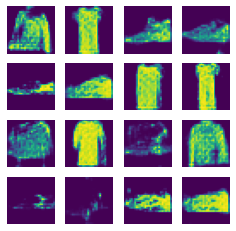

In [45]:
test_input = tf.random.normal([16, 100])
generate_images(generator, test_input)

## anime-faces

In [26]:
import os
image_root = "data/anime-faces"
image_names = os.listdir(image_root)
print(len(image_names))
print(image_names[:10])

51223
['903d68683065961dc9d991447f910dbc-0.jpg', '3ffa87a7f805fb48aa37da3576a381dc-0.jpg', 'e9a14640d078ad0e507ff5401e638f23-0.jpg', '9d720c90b79b6eef10c6c6f2742cbfeb-0.jpg', '063bf9a2307926370d2fb333c576d2da-0.jpg', '16a8bbe161c77409183139ab8e1f2166-0.jpg', '4e5429a86304b69f26d147a4fce54628-0.jpg', '0cccefeb5c74c8c9a60babfed86a6302-0.jpg', 'bc7bfa67b2a8a525fcd66139492f34a4-0.jpg', 'a5b17c482a35f169bd40ada152420962-1.jpg']


(96, 96, 3) <class 'numpy.ndarray'>


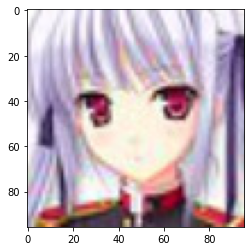

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline
img = plt.imread(os.path.join(image_root, image_names[0]))
print(img.shape, type(img))
plt.imshow(img)

In [ ]:
from tqdm import tqdm
x = []
for name in tqdm(image_names):
    img = plt.imread(os.path.join(image_root, name))
    x.append(img)

In [34]:
x = np.array(x)
x = (x - 127.5) / 127.5
buffer_size = 60000
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(buffer_size).batch(batch_size)

In [ ]:
from keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,use_bias=False,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Reshape((7,7,256)))
    assert model.output_shape == (None,7,7,256)#注意：batch size没有限制
    
    model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same',use_bias=False))
    assert model.output_shape == (None,7,7,128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))
    assert model.output_shape == (None,14,14,64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1,(5,5),strides=(2,2),padding='same',use_bias=False,activation='tanh'))
    assert model.output_shape == (None,28,28,1)
    
    return model